In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import random

In [2]:
# Critere de performance
def compute_pred_score(y_true, y_pred):
    y_pred_unq =  np.unique(y_pred)
    for i in y_pred_unq:
        if((i != -1) & (i!= 1) & (i!= 0) ):
            raise ValueError('The predictions can contain only -1, 1, or 0!')
    y_comp = y_true * y_pred
    score = float(10*np.sum(y_comp == -1) + np.sum(y_comp == 0))
    score /= y_comp.shape[0]
    return score

In [3]:
X_train_fname = '../data/training_templates.csv'
y_train_fname = '../data/training_labels.txt'
X_test_fname  = '../data/testing_templates.csv'
X_train = pd.read_csv(X_train_fname, sep=',', header=None).values
X_test  = pd.read_csv(X_test_fname,  sep=',', header=None).values
y_train = np.loadtxt(y_train_fname, dtype=np.int)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

random.seed(42)

t0 = time()

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

params = {'hidden_layer_sizes': [(128, 64), (172, 64), (128, 72)],
          'alpha': np.logspace(-6, 0, 20),
          'activation': ['logistic', 'tanh', 'relu']}

clf = GridSearchCV(MLPClassifier(verbose=False), params, cv=5, n_jobs=-1)
clf.fit(X_train_scaled, y_train)

print("Best parameters set found on training set:")
print(clf.best_params_)
print '\n'

print("Detailed classification report:")
print("The model is trained on the full training set with cross validation.")
print("The scores are computed on the full training set.")
y_true, y_pred = y_train, clf.predict(X_train_scaled)
print(classification_report(y_true, y_pred))

print "Done in %0.3fs." % (time()-t0)

Best parameters set found on training set:
{'alpha': 0.48329302385717521, 'activation': 'relu', 'hidden_layer_sizes': (128, 64)}


Detailed classification report:
The model is trained on the full training set with cross validation.
The scores are computed on the full training set.
             precision    recall  f1-score   support

         -1       0.99      0.99      0.99     52800
          1       0.99      0.99      0.99     52800

avg / total       0.99      0.99      0.99    105600

Done in 22537.518s.


In [16]:
from sklearn.ensemble import BaggingClassifier

nn = clf.best_estimator_
bagging = BaggingClassifier(base_estimator=nn, max_samples=0.8, n_jobs=-1)
bagging.fit(X_train_scaled, y_train)

BaggingClassifier(base_estimator=MLPClassifier(activation='relu', alpha=0.48329302385717521, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(128, 64), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=10, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [17]:
y_pred_train = bagging.predict(X_train_scaled)
score = compute_pred_score(y_train, y_pred_train)
print('Score sur le train : %s' % score)

Score sur le train : 0.0859848484848


In [18]:
y_pred_proba_train = bagging.predict_proba(X_train_scaled)

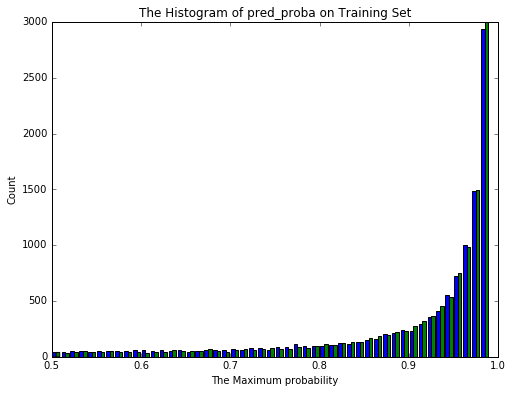

In [19]:
bins = np.arange(0.5, 1.0, 0.01)
plt.figure(1, figsize=(8,6))
plt.hist(y_pred_proba_train, bins=bins)
plt.title('The Histogram of pred_proba on Training Set')
plt.xlim(0.5, 1)
plt.xlabel('The Maximum probability')
plt.ylabel('Count')
plt.show()

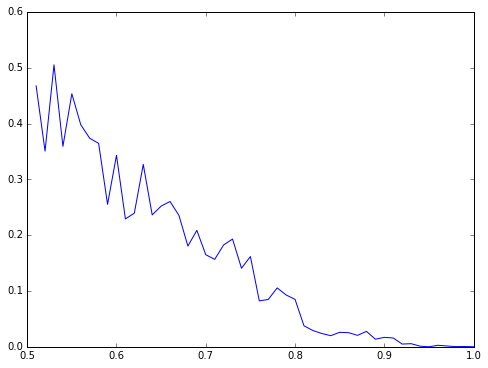

In [20]:
def error_rate(y_true, y_pred, y_pred_proba):
    y_pred_proba_max = np.amax(y_pred_proba, axis=1)
    rate = []
    bins = np.linspace(0.51, 1.00, 50)
    for b in bins:
        idx = (y_pred_proba_max < b) & (y_pred_proba_max >= b-0.01)
        y_t = y_true[idx]
        y_p = y_pred[idx]
        error = np.sum(y_t*y_p == -1)
        rate.append(float(error) / len(y_p))
    return rate

error_rate = error_rate(y_train, y_pred_train, y_pred_proba_train)
proba = np.linspace(0.51, 1.00, 50)
plt.figure(2, figsize=(8,6))
plt.xlim(0.5, 1)
plt.ylim(0, 0.6)
plt.plot(proba, error_rate)
plt.show()

In [26]:
y_pred = bagging.predict(X_test_scaled)
y_pred_proba = bagging.predict_proba(X_test_scaled)
for i in range(len(y_pred)):
    if max(y_pred_proba[i, :]) < 0.80:
        y_pred[i] = 0
np.savetxt('y_pred_nnb_0.80.txt', y_pred, fmt='%d')

for i in range(len(y_pred)):
    if max(y_pred_proba[i, :]) < 0.82:
        y_pred[i] = 0
np.savetxt('y_pred_nnb_0.82.txt', y_pred, fmt='%d')